In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir ./datasets
!mkdir ./datasets/agv

mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/agv’: File exists


In [ ]:
%ls drive/MyDrive/data

ls: cannot access 'drive/MyDrive/data': No such file or directory


In [ ]:
# !cp -r /content/drive/MyDrive/data/agv_images.zip /content/datasets
!cp -r /content/drive/MyDrive/data/agv_images_02.zip /content/datasets

cp: cannot stat '/content/drive/MyDrive/data/agv_images_02.zip': No such file or directory


In [ ]:
# !unzip /content/datasets/agv_images.zip -d /content/datasets/agv
!unzip /content/datasets/agv_images_02.zip -d /content/datasets/agv

Archive:  /content/datasets/agv_images_02.zip
replace /content/datasets/agv/forward/captured_20240418161706_26.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/datasets/agv/forward/captured_20240418161706_26.jpg  
replace /content/datasets/agv/forward/captured_20240418161707_27.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/datasets/agv/forward/captured_20240418161707_27.jpg  
  inflating: /content/datasets/agv/forward/captured_20240418161708_28.jpg  
  inflating: /content/datasets/agv/forward/captured_20240418161710_29.jpg  
  inflating: /content/datasets/agv/forward/captured_20240418161711_30.jpg  
  inflating: /content/datasets/agv/forward/captured_20240418161712_31.jpg  
  inflating: /content/datasets/agv/forward/captured_20240418161713_32.jpg  
  inflating: /content/datasets/agv/forward/captured_20240418161714_33.jpg  
  inflating: /content/datasets/agv/forward/captured_20240418161716_34.jpg  
  inflating: /content/datasets/agv/forward/capture

In [ ]:
import os
import csv
from glob import glob

dirname = "/content/datasets/agv/"
f_csv = open(os.path.join(dirname, "0_road_labels.csv"),'w', newline='')
wr = csv.writer(f_csv)
wr.writerow(["file","label"])

names = ['forward', 'right', 'left', 'none']

os.chdir('/content/datasets/agv/')

i=0
for name in names:
    # os.path.join() 함수를 사용하여 name과 "*.png"을 결합
    #glob: name 디렉토리 안에 있는 모든 PNG 파일을 찾음
    files = glob(os.path.join(name, "*.png"))
    for file in files:
        wr.writerow([file,str(i)])
        f_csv.flush()  # 버퍼에 있는 데이터를 파일에 쓰는 작업을 수행
    i=i+1
    #print(i)

 #라벨링
files = glob('forward/*.jpg')
for file in files:
    wr.writerow([file,'0'])
    f_csv.flush()

files = glob('right/*.jpg')
for file in files:
    wr.writerow([file,'1'])
    f_csv.flush()

files = glob('left/*.jpg')
for file in files:
    wr.writerow([file,'2'])
    f_csv.flush()

files = glob('none/*.jpg')
for file in files:
    wr.writerow([file,'2'])
    f_csv.flush()


os.chdir('/content/')

In [ ]:
!pwd

/content


In [ ]:

from glob import glob
files = glob('/content/datasets/agv/forward/*.png')
label =3
with open('output_file', 'w') as f:
    # 파일마다 작업 수행
    for file in files:
        # 파일명과 콤마를 파일에 쓰기
        f.write(file + ', ')

        # 입력된 변수 값을 파일에 쓰기
        f.write(str(label) + '\n')
        f.write('\n')


In [ ]:
!pip list | grep keras

keras                            2.15.0
tf_keras                         2.15.1


#1 수집한 데이터 불러오기

* 이미지 데이터를 텐서로 변환하고, 이를 훈련 또는 테스트에 사용할 수 있는 형식으로 준비하고, 라벨 확인

In [ ]:
# from tensorflow.keras.preprocessing import image as keras_image
from keras.preprocessing import image as keras_image
import os
import numpy as np
from tqdm import tqdm      # Progress bar 표시
from PIL import ImageFile  # Pillow : 이미지 편집, 포멧(JPEG, PNG, BMP, GIF)변환
import pandas as pd

dirname = "/content/datasets/agv/"

def image_to_tensor(img_path):
	img = keras_image.load_img(
		os.path.join(dirname, img_path), #이미지 데이터가 위치한 디렉토리
		target_size=(120,160))           #이미지 크기 변환
	x = keras_image.img_to_array(img)
	return np.expand_dims(x, axis=0)  #변환된 이미지의 텐서

def data_to_tensor(img_paths):  #이미지 경로의 데이터를 텐서로 변환
	list_of_tensors = [
		image_to_tensor(img_path) for img_path in tqdm(img_paths)]
	return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True   # PIL 라이브러리 설정: 로드할 때 발생하는 잘린 이미지 오류를 방지
# Load the data
data = pd.read_csv(os.path.join(dirname, "0_road_labels.csv"))

files = data['file']
targets = data['label'].values

tensors = data_to_tensor(files)

print(data.tail())
print(tensors.shape)
print(targets.shape)

100%|██████████| 477/477 [00:02<00:00, 226.55it/s]


                                     file  label
472  none/captured_20240418162019_189.jpg      2
473  none/captured_20240418162242_312.jpg      2
474  none/captured_20240418162207_282.jpg      2
475  none/captured_20240418162521_450.jpg      2
476  none/captured_20240418162505_436.jpg      2
(477, 120, 160, 3)
(477,)


#2 수집한 이미지 출력해 보기

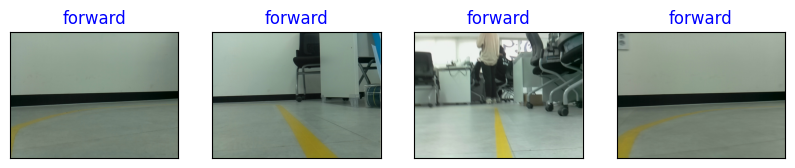

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Name list
names = ['forward', 'right', 'left', 'none']

def display_images(img_path, ax):
	img = cv2.imread(os.path.join(dirname, img_path))
	ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(10, 3))
for i in range(4):
	ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
	ax.set_title(names[targets[i+4]], color='blue')
	display_images(files[i+4], ax)
plt.show()

#3 훈련, 검증, 시험 데이터 분리하기

In [ ]:
# from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical    #정수형으로 된 클래스 레이블을 원-핫 인코딩된 형태로 변환
from sklearn.model_selection import train_test_split

tensors = tensors.reshape(-1,120,160,3)  #이미지의 크기가 120x160이고 3개의 채널(RGB)을 가지고 있음.
print(tensors.shape)
# -1: 나머지 차원의 크기를 고려해서 넘파이가 첫 차원의 텐서 크기 자동 설정함.
# 만약 100으로 정하면 첫 차원에 최소 100개의 이미지가 있어야 함.

tensors = tensors.astype('float32')/255  #전처리: tensors 배열을 부동소수점으로 변환하고 [0, 1] 범위로 정규화
targets = to_categorical(targets, 3)  #targets 배열에 대해 원-핫 인코딩을 수행

x_train, x_test, y_train, y_test = train_test_split(
		tensors,
		targets,
		test_size = 0.2,
		random_state = 1)

n = int(len(x_test)/2)  # n은 테스트 세트의 크기의 절반
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(477, 120, 160, 3)
(381, 120, 160, 3) (381, 3)
(48, 120, 160, 3) (48, 3)
(48, 120, 160, 3) (48, 3)


#4 인공신경망 학습시키기

## 모델 만들기

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([ #Sequential(레이어를 선형으로 쌓아 구성한 신경망) 모델을 생성
	tf.keras.layers.Conv2D(24, (5, 5), strides=(2, 2), padding="same",  #  5x5 크기의 커널로 연산을 수행
		activation='relu', input_shape=x_train.shape[1:]),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding="same", #strides: 입력 이미지의 크기를 2x2로 유지
		activation='relu'),
	tf.keras.layers.Dropout(0.2),
	# 드롭아웃 레이어 추가. 이는 과적합을 방지하기 위해 학습 중에 임의로 뉴런을 비활성화하는 역할을 함.
	# 확률 0.2로 설정되어 있으므로 각 학습 단계에서 20%의 뉴런이 비활성화됨.
	# padding='same' : 이미지 크기 유지
	tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
		activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Flatten(),                 # 다차원 배열을 1차원으로 평탄화함
	tf.keras.layers.Dense(100,activation='relu'), #100개의 뉴런을 가진 fully connected(Dense) 레이어를 추가
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Dense(50,activation='relu'),
	tf.keras.layers.Dropout(0.2),
	#tf.keras.layers.Dense(4,activation='softmax')
	#  출력 레이어로 3개의 클래스에 대한 소프트맥스 활성화 함수를 사용한 Dense 레이어를 추가
	tf.keras.layers.Dense(3,activation='softmax')
])

## 모델 summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 80, 24)        1824      
                                                                 
 dropout (Dropout)           (None, 60, 80, 24)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 40, 32)        19232     
                                                                 
 dropout_1 (Dropout)         (None, 30, 40, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 20, 64)        51264     
                                                                 
 dropout_2 (Dropout)         (None, 15, 20, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 20, 64)        3

## plot model

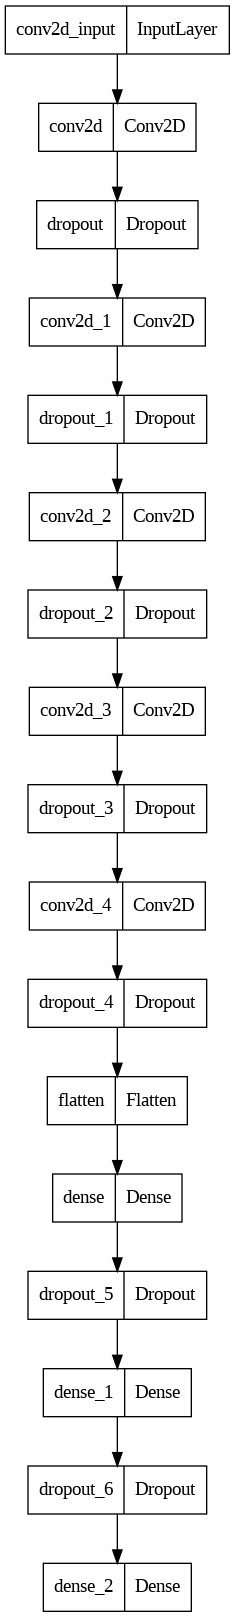

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

## 모델 컴파일

* 모델 학습과 평가를 위한 설정 지정

In [ ]:
model.compile(loss='categorical_crossentropy',
		          optimizer='adam', metrics=['accuracy'])

## call back 설정
 -  모델 학습 과정에서 효율적인 모니터링과 제어를 통해 학습을 최적화하기 위해 콜백을 설정함

* ModelCheckpoint : 모델의 학습 과정 중에 지정한 조건에 따라 현재 상태의 모델을 저장하는 콜백

* EarlyStopping : 모델 학습을 조기에 중지하는 콜백

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard

# save_best_only = True: 모델의 성능이 향상되었을 때만 저장하도록 하여 저장 공간을 절약함
check_point_cb = ModelCheckpoint('keras_agv_model.h5',save_best_only=True)
#check_point_cb = ModelCheckpoint('keras_agv_model.h5',save_best_only=False)

# restore_best_weights=True: 학습을 조기 종료할 때 모델의 가중치를 최상의 성능을 보였던 지점의 가중치로 복원함
early_stopping_cb = EarlyStopping(patience=20, monitor='val_loss',
                                  restore_best_weights=True)

## 학습

In [ ]:
#history = model.fit(x_train, y_train, epochs=40,
#                    validation_data=(x_valid, y_valid),
#                    callbacks=[check_point_cb,early_stopping_cb])
history = model.fit(x_train, y_train, epochs=40,
                    validation_data=(x_valid, y_valid))

Epoch 1/40
12/12 [==============================] - 10s 599ms/step - loss: 1.0027 - accuracy: 0.5906 - val_loss: 0.8540 - val_accuracy: 0.6875
Epoch 2/40
12/12 [==============================] - 5s 429ms/step - loss: 0.9561 - accuracy: 0.5958 - val_loss: 0.9183 - val_accuracy: 0.6875
Epoch 3/40
12/12 [==============================] - 7s 636ms/step - loss: 0.9698 - accuracy: 0.6037 - val_loss: 0.9302 - val_accuracy: 0.6875
Epoch 4/40
12/12 [==============================] - 5s 446ms/step - loss: 0.9612 - accuracy: 0.6037 - val_loss: 0.8825 - val_accuracy: 0.6875
Epoch 5/40
12/12 [==============================] - 7s 617ms/step - loss: 0.9729 - accuracy: 0.6037 - val_loss: 0.9308 - val_accuracy: 0.6875
Epoch 6/40
12/12 [==============================] - 5s 458ms/step - loss: 0.9881 - accuracy: 0.6037 - val_loss: 0.8876 - val_accuracy: 0.6875
Epoch 7/40
12/12 [==============================] - 8s 672ms/step - loss: 0.9505 - accuracy: 0.6037 - val_loss: 0.8399 - val_accuracy: 0.6875
Epoch

## 그래프 그리기

* 그래프 보기
* 학습 모델 저장

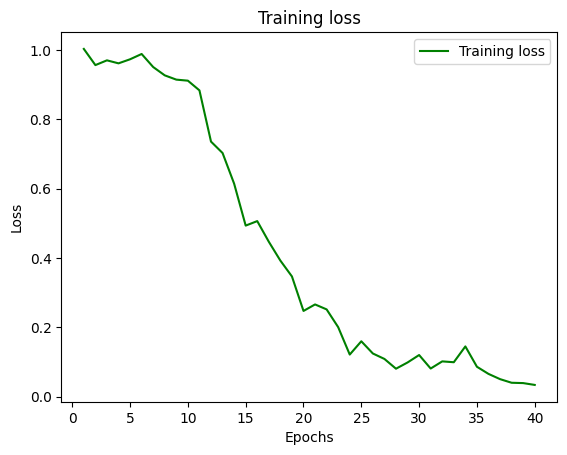

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save("keras_agv_model.h5")

#5 시험 데이터로 확인해 보기

In [ ]:
# from tensorflow.keras.models import load_model
from keras.models import load_model

model1 = load_model('keras_agv_model.h5')

# Model predictions for the testing dataset
y_test_predict = model1.predict(x_test)
print(y_test_predict.shape, y_test_predict[0])
y_test_predict = np.argmax(y_test_predict,axis=1)
print(y_test_predict.shape, y_test_predict[0])

2/2 [==============================] - 0s 53ms/step
(48, 3) [9.9999994e-01 1.9502179e-13 4.6353735e-10]
(48,) 0


* (35, 3): 35개 테스트 데이터 샘플 수, 3개의 가능 결과 값
* [9.9999934e-01 9.7575228e-09 6.1769833e-07]: [0번일 확률 0.99, 1번일 확률 0.000000009, 2번일 확률: 0.00000006]
* 즉, 0번일 것이라고 예측함

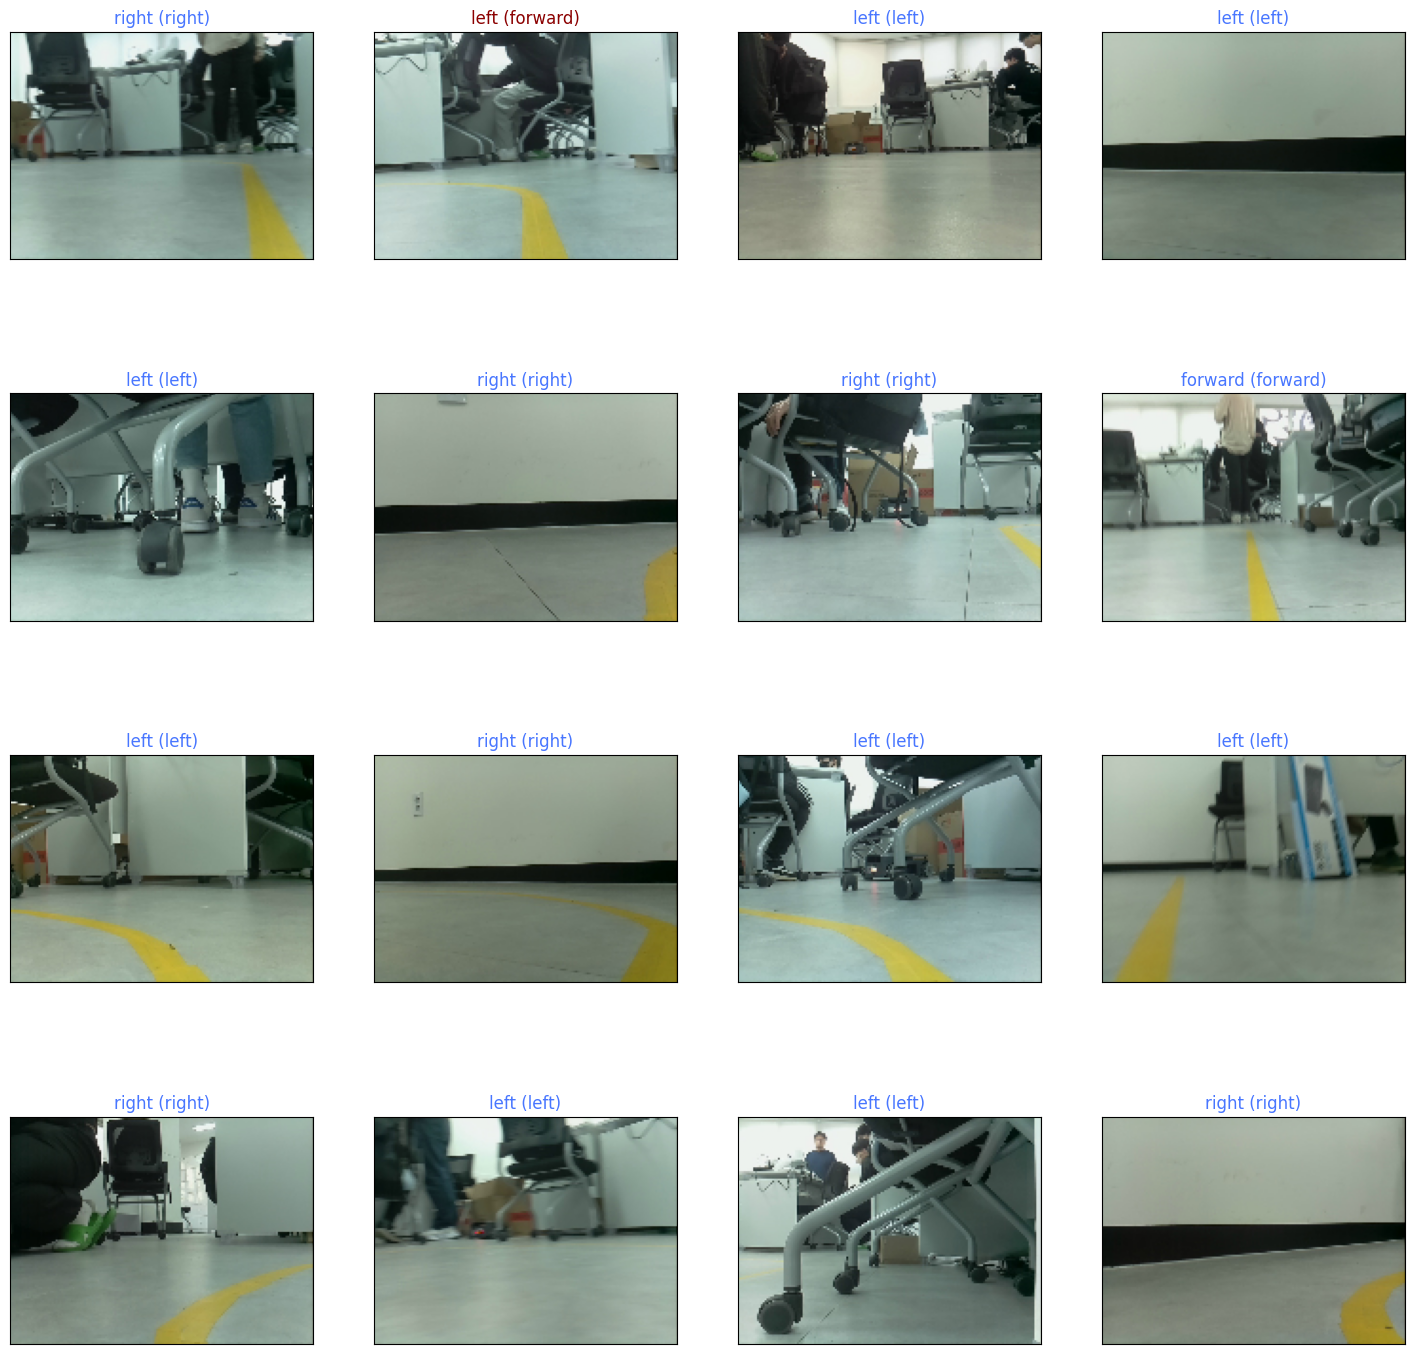

In [ ]:
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16,
                        replace=False)):
	ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
	ax.imshow(np.squeeze(x_test[idx]))
	pred_idx = y_test_predict[idx]
	true_idx = np.argmax(y_test[idx])
	ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
		color=("#4876ff" if pred_idx == true_idx else "darkred"))
plt.show()

# 샘플 데이터셋

https://drive.google.com/file/d/1g5KZMmFh21q6V3YZmevzKtI6ultSLlo1/view?usp=drive_link